# Wind-AE Quick Start Tutorial <a id='top'></a>
### (Each numbered section can be run independently)
#### Total runtime: ~4 min
#### Time to read: ~30 min
**Note:** Units are cgs unless otherwise specified. It is not necessary to use Astropy units.

**Reminder: Relaxation codes are inherently finicky! Have patience and try ramping parameters in different orders or taking smaller steps in parameter space if the solver gets stuck.**

Be aware that extremely high and low gravity planets push the physical and numerical limits of this model, so caution is suggested with such solutions.

In [1]:
from wind_ae.wrapper.relax_wrapper import wind_simulation as wind_sim
from wind_ae.wrapper.wrapper_utils.plots import energy_plot, six_panel_plot, quick_plot 
from wind_ae.wrapper.wrapper_utils import constants as const
from wind_ae.wrapper.wrapper_utils.system import system
from wind_ae.wrapper.wrapper_utils.spectrum import spectrum
import wind_ae.McAstro.atoms.atomic_species as McAtom

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

## 1. [Ramping to a new planet](#newplanet) 
- [Loading initial guess](#loadguess)
- [Ramping to planet](#newplanet2)
- [Interacting with solution outputs](#windsoln)
- [Mass Loss rate ($\dot{M}$)](#Mdot)
- [Plotting](#plot)
- [Saving solutions](#save)
    - [Advanced: Lowering lower boundary](#bcs)

## 2. [Ramping stellar spectrum](#spectrum) 
- [Ramping wavelength range and flux](#range)
- [Ramping to custom spectrum](#custom)

## 3. [Adding Metals](#metals)
- [Adding metals](#metals)
- [Ramping metallicity](#metallicity)

## 4. [Easy output file](#output)

## 1. Ramping to a new planet <a id='newplanet'></a>
### Load Initial Guess <a id='loadguess'></a>
Load initial guess from which the relaxation code will ramp to your desired parameters. `calc_postfacto` takes the time to compute all of the post-facto variables. Post facto calculations are not necessary to run the ramping.

**Note:** `sim.load_planet('saves/filename')` will load the guess parameters into the input files in `Inputs/` and may interrupt ongoing runs of the relaxation code. To do computations with or plot a solution without ovewritting the `Inputs/` files, use `sim.load_uservars('saves/filename')`. This is useful when checking the outputs of currently running calculations (e.g., `sim.load_uservars('wind_ae/saves/windsoln.csv')`) or to perform analysis while `Wind-AE` is solving for another planet (`sim.load_uservars('saves/[path-to-a-prior-solution]')`).

In [2]:
sim = wind_sim()
sim.load_planet('../saves/starting_solutions/start_HotJupiter_XUV_H-He.csv') #HD209458b
sim.system.print_system()

Atmosphere Composition
  Species:   HI,        HeI
  Mass frac: 8.00e-01, 2.00e-01

Loaded Planet:
  System parameters (cgs)               # Normalized units
    Mp:        1.330000e+30 g           #     0.70 MJ
    Rp:        1.000000e+10 cm          #     1.40 RJ
    Mstar:     1.988416e+33 g           #     1.00 Msun
    semimajor: 7.480000e+11 cm          #     0.05 au
    Ftot:      1.095713e+03 erg/cm^2/s  # 2.35e+02 FuvEarth
    Lstar:     6.807420e+33 erg/s       # 1.78e+00 Lsun



#### To run relaxation code (NOT necessary for ramping)
To run relaxation code for whatever solution is loaded into the `wind_ae/inputs/` files, run `sim.run_wind()` which returns 0 if successfully converges on solution.

Any time a simulation is run through the python wrapper, the solution generated at each step is saved in [`wind_ae/saves/windsoln.csv`](files/../../wind_ae/saves/windsoln.csv) and the solution is copied into [`wind_ae/inputs/guess.inp`](files/../../wind_ae/inputs/guess.inp) to be the guess for for the next iteration.

### Ramping to "new planet" <a id='newplanet2'></a>        -         [Top](#top)

New planets can be created by supplying a planetary mass ($M_\mathrm{p}$), planetary radius ($R_\mathrm{p}$), stellar mass ($M_\star$), semimajor-axis ($a$), stellar *bolometric* luminosity ($L_\star$) and the total integrated ionizing flux ($F_\mathrm{tot}$) to the `system` object.


To run relaxation code for whatever solution is loaded into the `inputs/` files, run `sim.run_wind()` which returns `0` if successful.

A ramping output of `5` also means that it ramped successfully, but that one or more of the polishing steps could not be completed. Effects on mass loss rates and wind structure are minimal, but confirm that the result is acceptable by plotting the `energy_plot()` and `six_panel_plot()` or `quick_plot()`.

**Helpful Hint**: Take advantage of the McAstro cgs constants object (`const`). These do not contain units and **no functions accept astropy units**.

In [3]:
example = system(0.8*const.Mjupiter, #planet mass
                 1.5*const.Rjupiter, #planet optical transit radius
                 1.988416e+33,       #stellar mass
                 748000000000.0,     #semimajor axis 
                 1095.712977126,     #stellar flux at planet's semimajor axis
                 6.80742e+33,        #stellar bolometric luminosity - 
                                     #   (used to physically approximate lower boundary conditions, 
                                     #    e.g., temp and density at 1 microbar)
                 name='example planet')

example.print_system(norm='Jupiter')

example planet:
  System parameters (cgs)               # Normalized units
    Mp:        1.518819e+30 g           #     0.80 MJ
    Rp:        1.072380e+10 cm          #     1.50 RJ
    Mstar:     1.988416e+33 g           #     1.00 Msun
    semimajor: 7.480000e+11 cm          #     0.05 au
    Ftot:      1.095713e+03 erg/cm^2/s  # 2.35e+02 FuvEarth
    Lstar:     6.807420e+33 erg/s       # 1.78e+00 Lsun



In [4]:
%%time
sim.ramp_to(system=example,intermediate_converge_bcs=True,integrate_out=True,final_polish=True,make_plot=False) 
print("\n\n Mass loss rate using sim.ramp_to(intermediate_converge_bcs=True):",
      f" {sim.windsoln.Mdot:.4e} g/s\n")

Ramping Ftot from 1.096e+03 to 1.096e+03 ergs/s/cm2.                                                     
  Ftot already done.                                                 
Ramping Mp from 1.330e+30 to 1.519e+30 g AND Rp from 1.000e+10 to 1.072e+10 cm.
  Final:  Mp:1.518819e+30 & Rp:1.072380e+10, M_delta:0.07652                                                                      
Polishing up boundary conditions...
   ...Trying: 6.669e-05, 1.626e-04. Current 9.123e-05, 1.822e-04. Goal 6.669e-05, 1.626e-04.                                      
  All boundary conditions succesfully polished to self-consistency.                                                                                                    

Ramping Mstar from 1.988e+33 to 1.988e+33 AND semimajor from 7.480e+11 to 7.480e+11 AND Lstar from 6.807e+33 to 6.807e+33.
  Mstar already done.
  semimajor already done.
  Lstar already done.
Polishing up boundary conditions...
 Success! Average Ncol difference: 9.85e-03     

**To save time** at a small accuracy cost, set `intermediate_converge_bcs=False`, though if simulation gets stuck, polishing boundary conditions between each ramping function by setting `intermediate_converge_bcs=True` may be advisable. 

Since many of the use cases of this model require multiple iterations with changing just a few parameters (e.g., grids, evolutions, etc.) it is possible to slightly speed up computations by ramp only the relevant variables using:

- `ramp_Ftot(goal_Ftot,converge_bcs=)` - to ramp just stellar flux
- `ramp_grav(system=example,converge_bcs=)` - to ramp just planet mass and/or radius
- `ramp_star(system=example,converge_bcs=)` - to ramp semimajor axis, Mstar, or Lstar

Speed comparisons* follow:

$*$ *Need to reload HD209 to compare apples to apples for speed. This is because when sim runs, it loads most recent solution to be the next guess. If we ramped without reloading the HD209 solution as a guess, we would be ramping from the recently solved-for example planet with 0.8 $M_J$, 1.5 $R_J$ to the same planet with 0.8 $M_J$, 1.5 $R_J$.*

In [5]:
#Just turning off intermediate polishing
sim.load_planet('../saves/starting_solutions/start_HotJupiter_XUV_H-He.csv',
                calc_postfacto=False,print_atmo=False) 
#expediting because we don't need to do the post facto calculations/

%time sim.ramp_to(system=example,intermediate_converge_bcs=False,integrate_out=True,final_polish=True) 
print("\n\nMass loss rate using sim.ramp_to(intermediate_converge_bcs=False):",
      f" {sim.windsoln.Mdot:.4e} g/s\n")

Ramping Ftot from 1.096e+03 to 1.096e+03 ergs/s/cm2.                                                     
  Ftot already done.                                                 
Ramping Mp from 1.330e+30 to 1.519e+30 g AND Rp from 1.000e+10 to 1.072e+10 cm.
  Final:  Mp:1.518819e+30 & Rp:1.072380e+10, M_delta:0.07652                                                                      
Ramping Mstar from 1.988e+33 to 1.988e+33 AND semimajor from 7.480e+11 to 7.480e+11 AND Lstar from 6.807e+33 to 6.807e+33.
  Mstar already done.
  semimajor already done.
  Lstar already done.
Polishing up boundary conditions...
  ...Attempting Final Ncol Convergence.                                                                                           
Successfully converged Rmax to 6.128896 (Ncol also converged).                                                                                                    

   ...Trying: 1.240e-04, 2.510e-05. Current 6.196e-05, 4.911e-05. Goal 1.240e-04, 2.510e-

In [6]:
#Turning off all polishing (Fastest)
sim.load_planet('../saves/starting_solutions/start_HotJupiter_XUV_H-He.csv',
                calc_postfacto=False,print_atmo=False) 
#expediting because we don't need to do the post facto calculations/

%time sim.ramp_to(system=example,intermediate_converge_bcs=False,integrate_out=False,final_polish=False) 
print("\n\nMass loss rate using sim.ramp_to(intermediate_converge_bcs=False):",
      f" {sim.windsoln.Mdot:.4e} g/s\n")

Ramping Ftot from 1.096e+03 to 1.096e+03 ergs/s/cm2.                                                     
  Ftot already done.                                                 
Ramping Mp from 1.330e+30 to 1.519e+30 g AND Rp from 1.000e+10 to 1.072e+10 cm.
  Final:  Mp:1.518819e+30 & Rp:1.072380e+10, M_delta:0.07652                                                                      
Ramping Mstar from 1.988e+33 to 1.988e+33 AND semimajor from 7.480e+11 to 7.480e+11 AND Lstar from 6.807e+33 to 6.807e+33.
  Mstar already done.
  semimajor already done.
  Lstar already done.
CPU times: user 65.4 ms, sys: 67.2 ms, total: 133 ms
Wall time: 6.87 s


Mass loss rate using sim.ramp_to(intermediate_converge_bcs=False):  1.9418e+10 g/s



Since we are just ramping $M_P$ and $R_P$, these values are handled by `sim.ramp_grav()` so we can actually forgo the  `sim.ramp_to(system)` entirely. We can always polish the boundary conditions to self-convergence later by running `sim.polish_bcs()`

In [7]:
sim.load_planet('../saves/starting_solutions/start_HotJupiter_XUV_H-He.csv',print_atmo=False) 
#expediting because we don't need to do the post facto calculations

%time sim.ramp_grav(system=example,converge_bcs=False,make_plot=False) 
print("\n\nMass loss rate using sim.ramp_grav(converge=False):",
      f" {sim.windsoln.Mdot:.4e} g/s\n")

Ramping Mp from 1.330e+30 to 1.519e+30 g AND Rp from 1.000e+10 to 1.072e+10 cm.
  Final:  Mp:1.518819e+30 & Rp:1.072380e+10, M_delta:0.07652                                                                      
CPU times: user 68.6 ms, sys: 65.3 ms, total: 134 ms
Wall time: 6.86 s


Mass loss rate using sim.ramp_grav(converge=False):  1.9418e+10 g/s



#### A note about `Wind-AE`'s ramping scheme
In the case of this example, `Wind-AE` likely could have ramped in just one step, since the goal was so close in parameter space. Future versions of `Wind-AE` may include a smarter ramping algorithm, but, for the time being, the ramping algorithm is designed to take adaptive step sizes that allow to more robustly navigate the large jumps in parameter space of which the relaxation method is infamously intolerant.

To run manually outside of the ramping scheme, load your guess
```
sim = wind_sim()
sim.load_planet('[path-to-planet]')
```
Then edit the parameters directly in the [`wind_ae/inputs/`](files/../../wind_ae/inputs/) directory (PAY ATTENTION TO UNITS) or write the input values using
```
sim.inputs.write_bcs()
sim.inputs.write_planet()
sim.inputs.write_flags()
sim.inputs.write_physics_params()
...
etc.
```
Finally, run using the command line (`cd wind_ae`, then `./bin/relax_ae`) or in Python via
```
sim.run_wind()
```

### Solution outputs (windsoln object) <a id='windsoln'></a>
To interact with wind solution object, use `sim.windsoln`.
- Dependent variables returned by the relaxation code: `'r'`,`'v'`,`'T'`,`'rho'`, `'Ys_[species]'`, `'Ncol_[species]'`, `E`, etc.

- Dependent variables calculated post facto by running `sim.windsoln.add_user_vars()` or loading solution from save file as `sim.load_uservars('saves/filename')`: `'mu'`,`'heat_ion'` (etc.), . See below.

- Parameters of the solution: `sim.windsoln.Rp`,`sim.windsoln.E_wl`, `sim.windsoln.Ys_rmin`, `sim.windsoln.species_list`, etc.

- Tuples of the solution parameters: `sim.windsoln.planet_tuple`,`sim.windsoln.bcs_tuple`, etc.

In [8]:
sim.windsoln.add_user_vars()
sim.windsoln.soln.columns

Index(['r', 'rho', 'v', 'T', 'Ys_HI', 'Ys_HeI', 'Ncol_HI', 'Ncol_HeI', 'q',
       'z', 'n_e', 'n_H', 'n_HI', 'n_HII', 'n_He', 'n_HeI', 'n_HeII', 'n_tot',
       'mu', 'P', 'ram', 'cs', 'Mach', 'Hsc', 'heat_ion', 'heat_no2nd',
       'ion_rate_HI', 'ion_rate_HeI', 'euv_ion_rate_HI', 'euv_ion_rate_HeI',
       'heating_rate_HI', 'heating_rate_HeI', 'DlnP', 'mfp_hb', 'mfp_Co',
       'mfp_mx', 'Kn_hb_HI', 'Kn_Co_HI', 'Kn_mx_HI', 'recomb_HI', 'advec_HI',
       'recomb_HeI', 'advec_HeI', 'cool_lyman', 'cool_PdV', 'cool_cond',
       'cool_rec', 'boloheat', 'bolocool', 'cool_grav', 'e_therm',
       'heat_advect', 'cum_heat', 'sp_kinetic', 'sp_enthalpy', 'sp_grav',
       'bern_rogue', 'bern_isen', 'bern', 'ad_prof', 'static_prof',
       'static_rho', 'static_P', 'static_T', 'del_ad', 'Gamma_2', 'Gamma_3'],
      dtype='object')

### Get Mass Loss Rate <a id='Mdot'></a>
To account for geometric and circulation effects, the substellar $\dot{M}$ is multiplied by a factor of 0.33 in the post-facto calculations in the python wrapper.

Given the uncertainties inherent in 1D modeling of mass loss, $\dot{M}$ differences of a few to a few tens of percent difference are negligible.

In [9]:
Mdot = sim.windsoln.Mdot
print(f"Mass loss rate of {Mdot:.3e} g/s")

Mass loss rate of 1.941e+10 g/s


### Plots <a id='plot'></a>        -         [Top](#top)

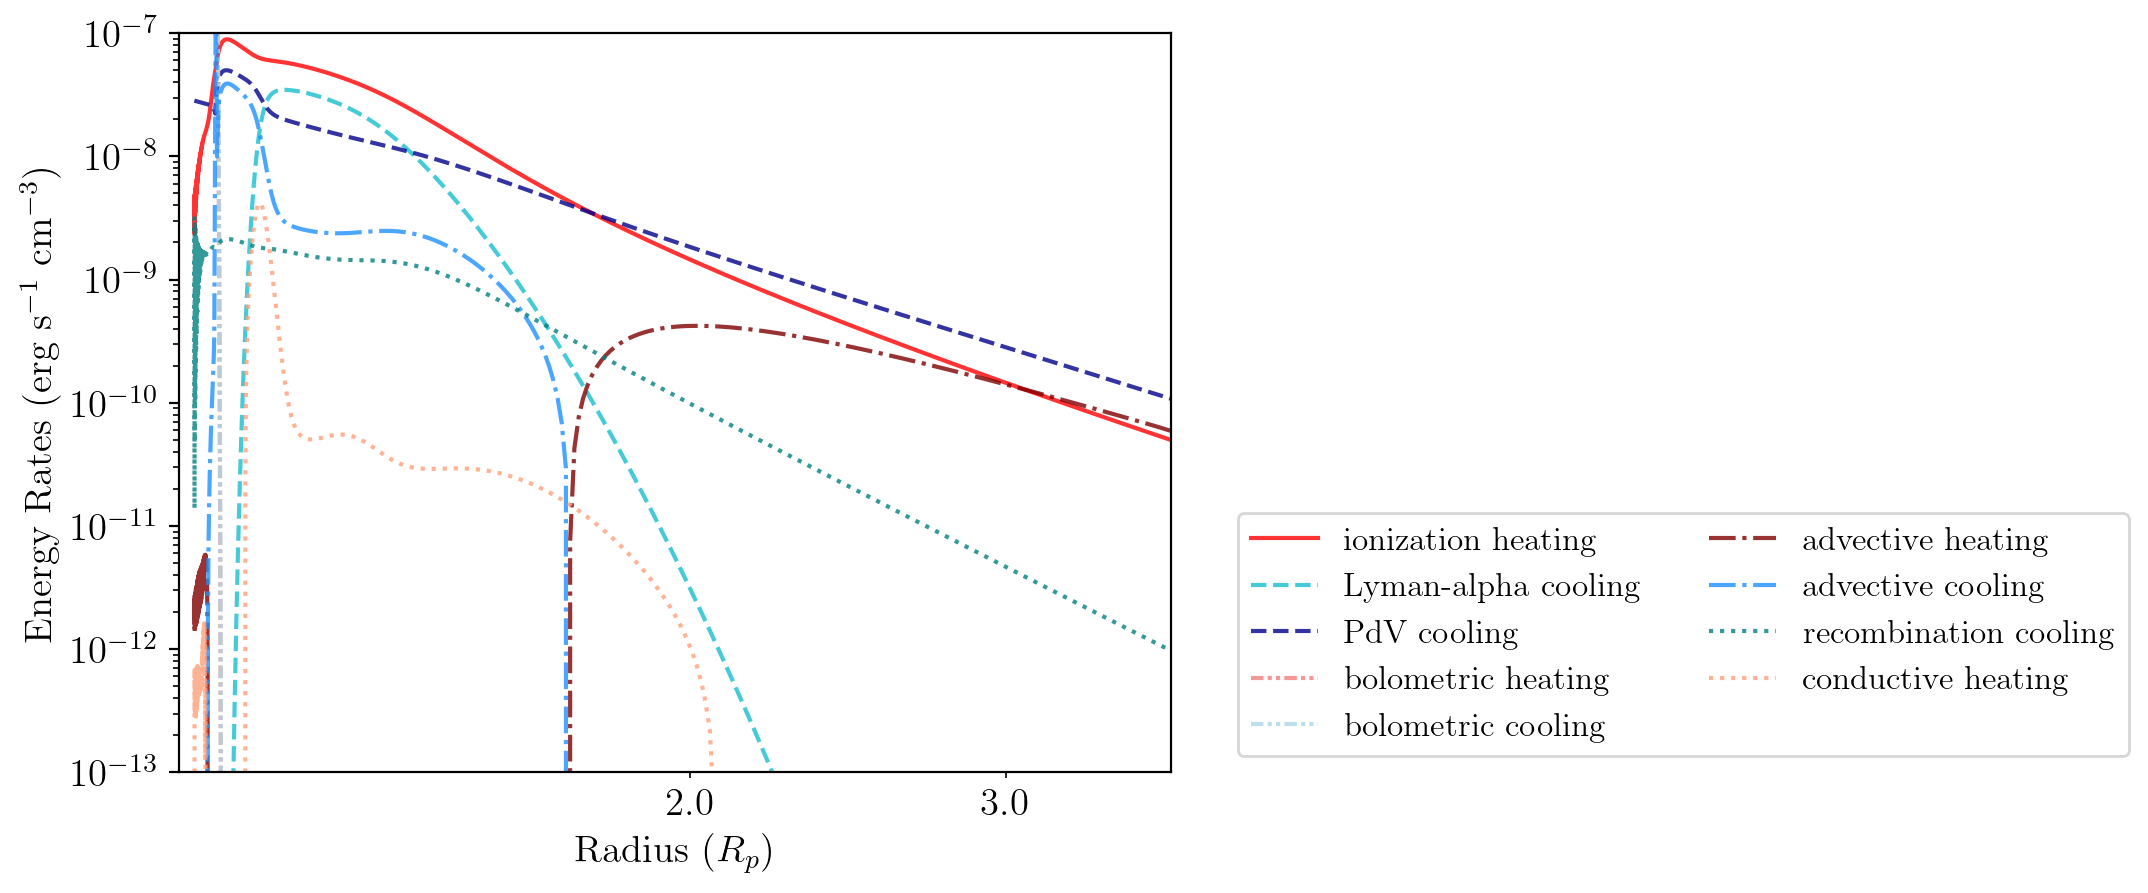

In [10]:
energy_plot(sim.windsoln)

***** HD 209548b: Mdot = 2.01e+10 g/s *****
***** Example Planet: 1.50R$_J$, 0.80M$_J$: Mdot = 1.94e+10 g/s *****


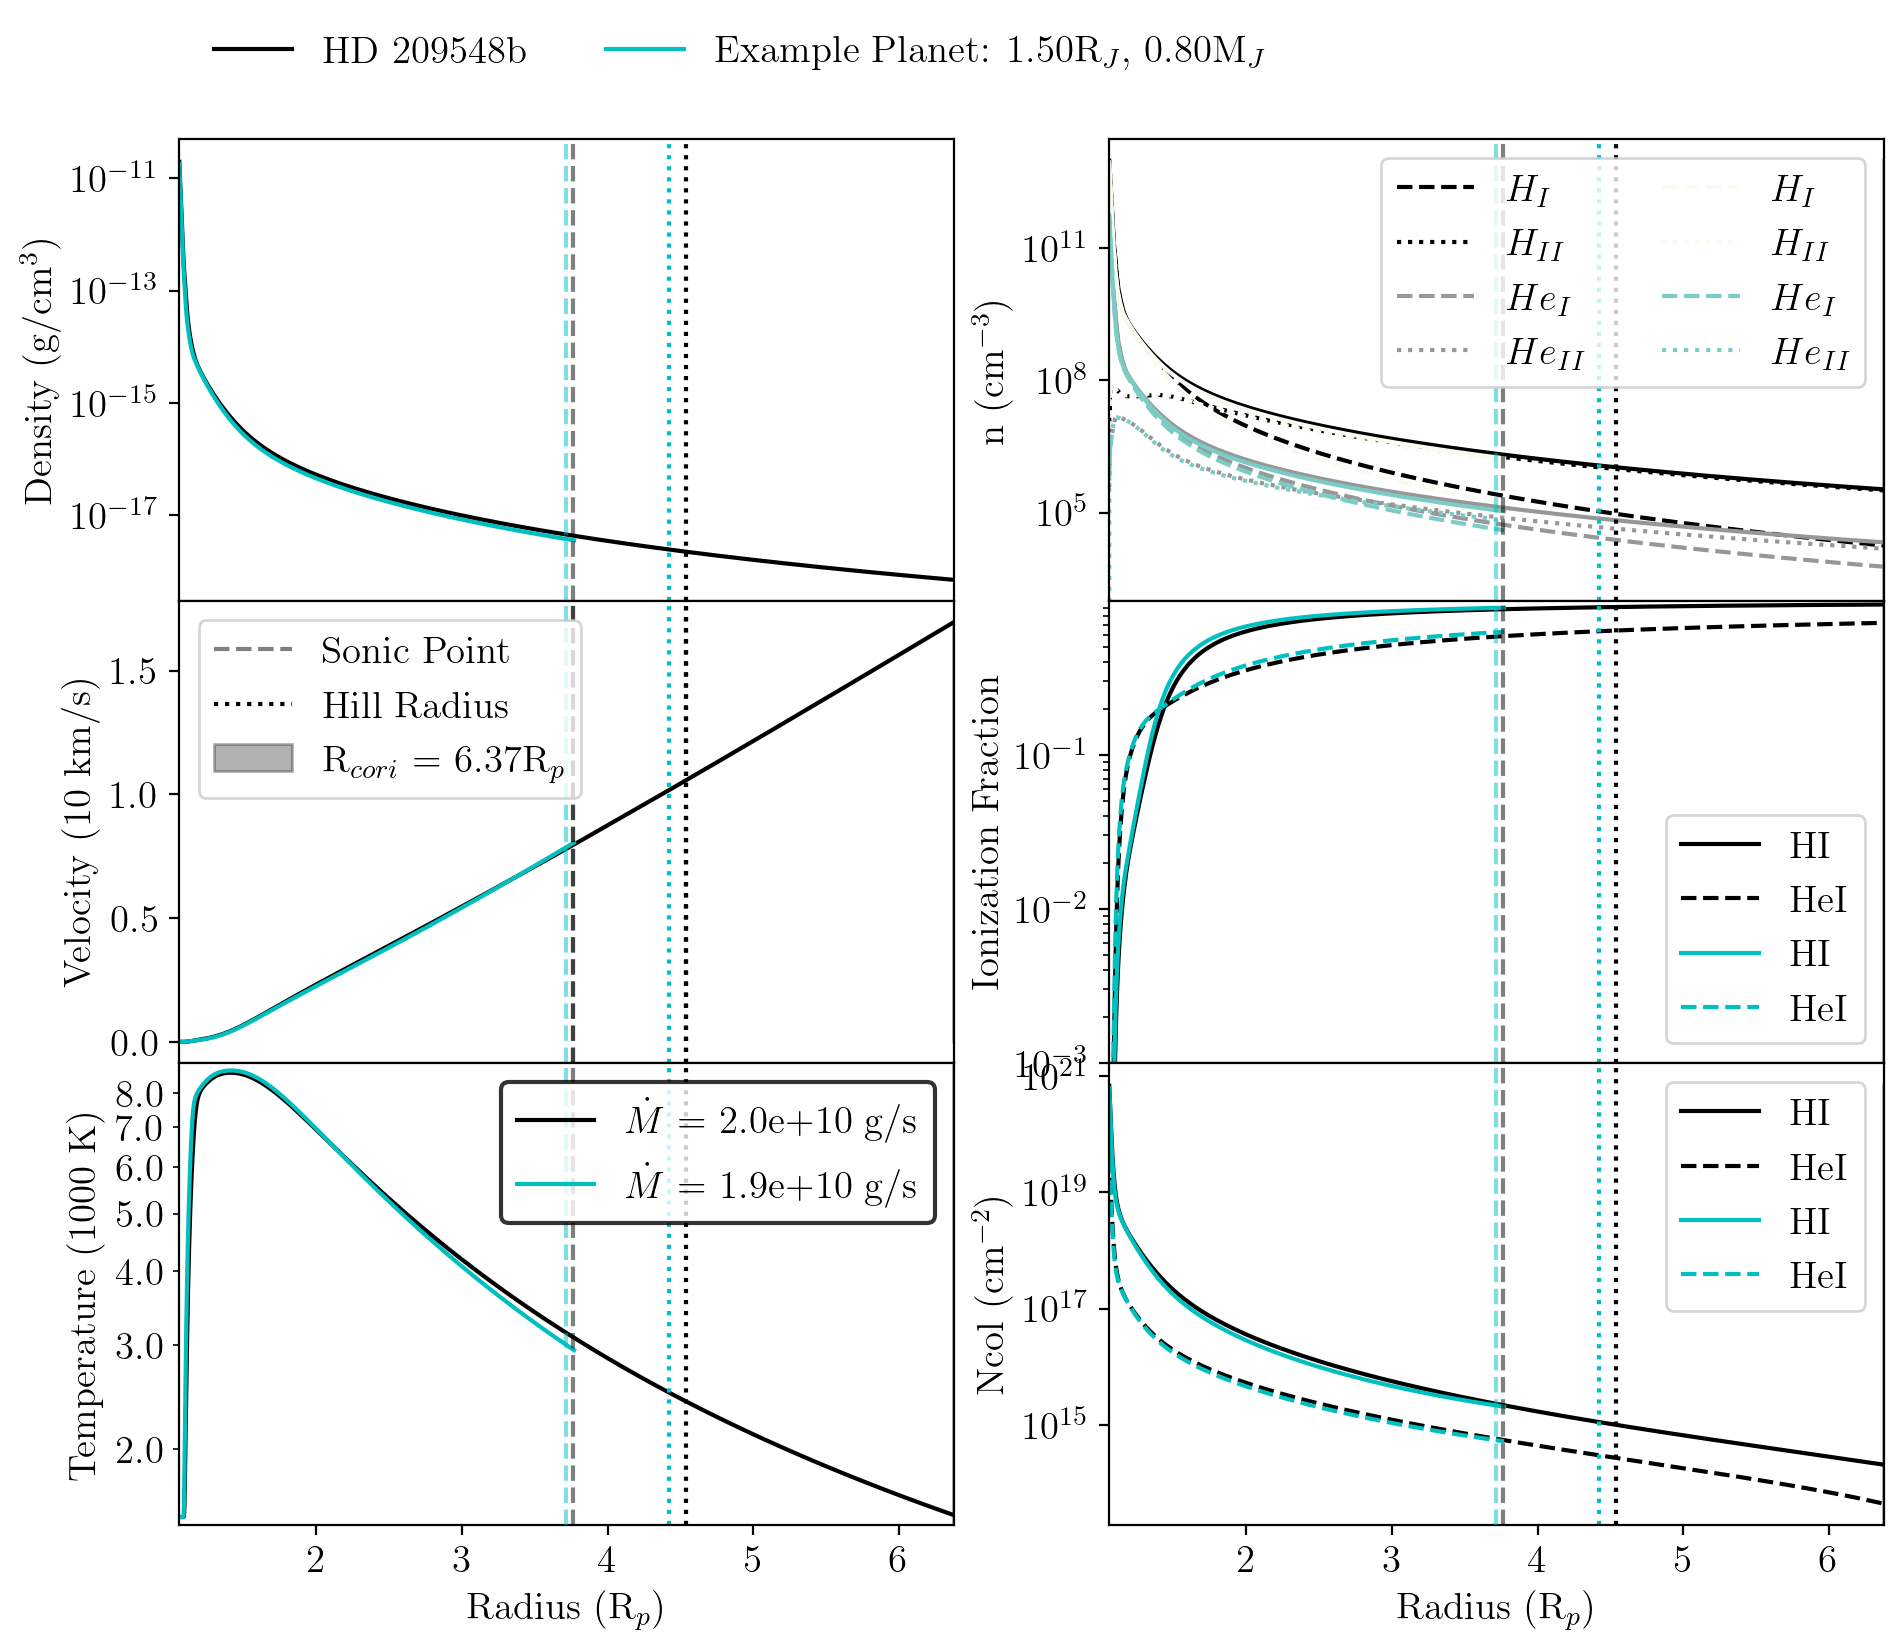

In [11]:
#Compare to an existing solution
#load JUST the post-facto calculations from an existing solution (does not load solution to be run or ramped)
sim_HD209 = wind_sim()
sim_HD209.load_uservars('../saves/starting_solutions/start_HotJupiter_XUV_H-He.csv')

#perform the post-facto calculations for the planet currently in the windsoln object
# sim.windsoln.add_user_vars() 
#alternatives: 
#sim.load_uservars('saves/windsoln.csv')
#sim.load_planet('saves/windsoln.csv',expedite=False)

#To plot comparisons
ax = six_panel_plot(sim_HD209.windsoln,
                    label='HD 209548b',c='k')

R = sim.windsoln.Rp/const.Rjupiter
M = sim.windsoln.Mp/const.Mjupiter
six_panel_plot(sim.windsoln,
               first_plotted=False,ax=ax,
               label=f'Example Planet: {R:.2f}R$_J$, {M:.2f}M$_J$',
               c='c')
plt.show()

### Save Planet <a id='save'></a>
To polish self consistently polish the boundary conditions, run `sim.polish_bcs(converge_Rmax=)` or set `sim.save_planet(polish=True)`.

In [12]:
sim.polish_bcs()

Polishing up boundary conditions...
  ...Attempting Final Ncol Convergence.                                                                                           
Successfully converged Rmax to 6.128946 (Ncol also converged).                                                                                                    

   ...Trying: 1.240e-04, 2.510e-05. Current 6.195e-05, 4.911e-05. Goal 1.240e-04, 2.510e-05.                                      
  All boundary conditions succesfully polished to self-consistency.                                                                                                    



0

In [13]:
sim.save_planet('../saves/Tutorial_examples/example_13.6-2000eV_solar_H-He.csv',
                overwrite=True)

Saving ../saves/Tutorial_examples/example_13.6-2000eV_solar_H-He.csv


## 2. Ramping Stellar Spectrum <a id='spectrum'></a>         -           [Top](#top)
### Changing spectrum range <a id='range'></a>
`Fnorm` flux in units of ergs/s/cm2 at the planet in the range defined by `norm_spec_range`. Set the full range of your spectrum in `goal_spec_range`. If `Fnorm=0` (default), it will normalize to the current flux value in the norm_spec_range in your spectrum. If `goal_spec_range=[]` (default), it will maintain the same range bounds. 

In [14]:
sim = wind_sim()
sim.load_planet('../saves/Tutorial_examples/example_13.6-2000eV_solar_H-He.csv',
               print_atmo=False)

current_wl_range = sim.windsoln.spec_resolved
eV_range = (const.hc/current_wl_range) / const.eV
print(f"Current spectrum range is {current_wl_range}cm ([{eV_range[1]:.1f},{eV_range[0]:.1f}]eV)")

Current spectrum range is [6.00e-08 9.12e-06]cm ([13.6,2066.4]eV)


If we want to maintain or change the current flux over the specified wavelength (or energy) range, we can do so.

Note that in the case below, we are keeping the flux over the EUV range (13.6-100 eV) constant by increasing Ftot as the spectrum range increases from 13.6-2000eV to 10.3-2000 eV.

In [15]:
sim.ramp_spectrum(Fnorm=0,norm_spec_range=[13.6,100],
                  goal_spec_range=[10.3,2000],units='eV')

Spectrum will be normalized such that sum(Flux[12.40, 91.16]nm) = 979 ergs/s/cm2.                                                                                                    

Goal: [  0.61992127 120.37306285] nm                                                                                                    

Ramped spectrum wavelength range, now normalizing spectrum. 
Ramping Ftot from 1.096e+03 to 1.458e+03 ergs/s/cm2.                                                     
  Final:  Ftot:1.458103e+03, delta:0.001327                                                                      


0

Atmosphere Composition
  Species:   HI,        HeI
  Mass frac: 8.00e-01, 2.00e-01



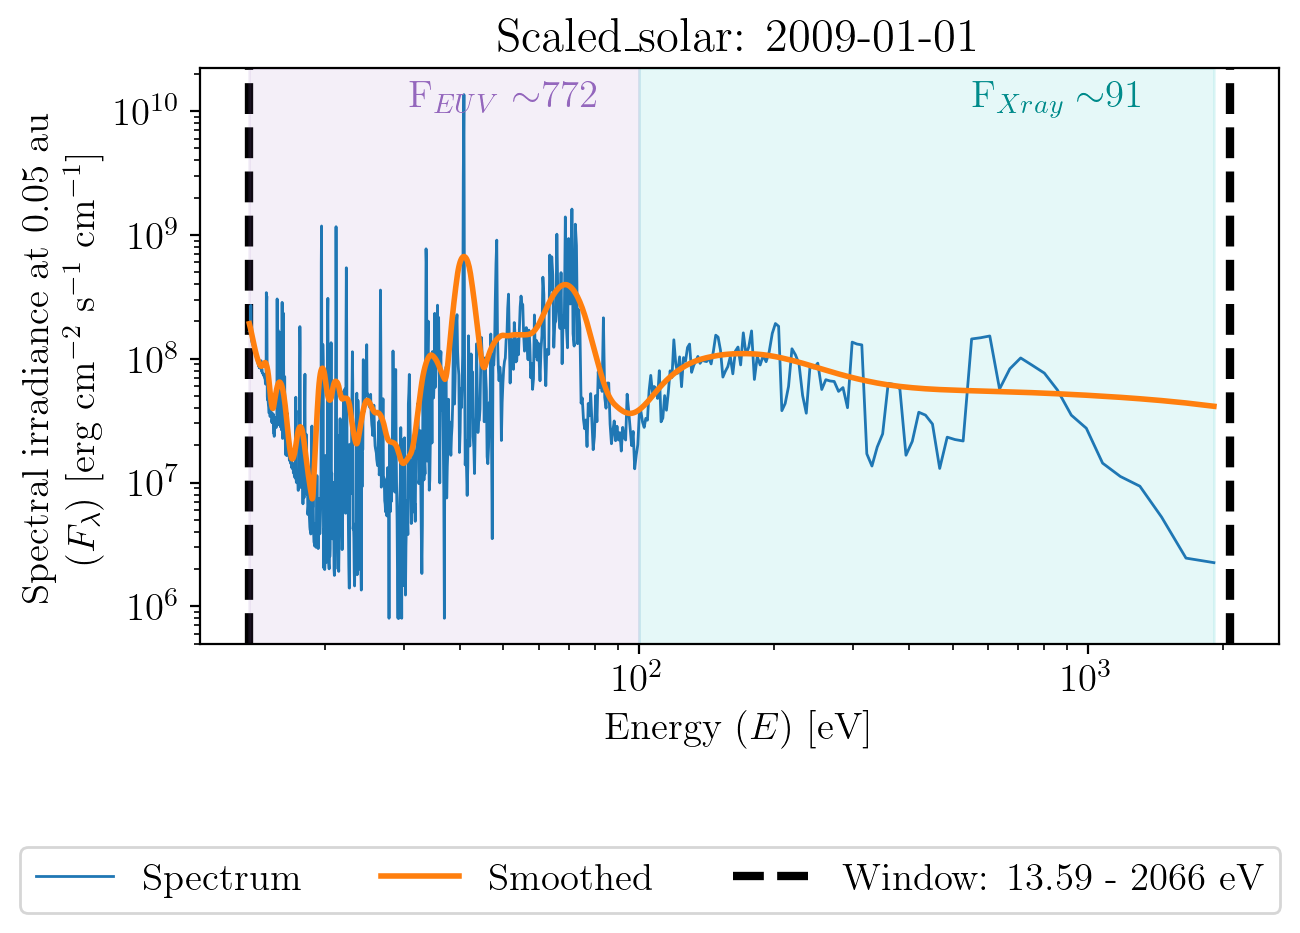

In [16]:
sim.load_planet('../wind_ae/saves/windsoln.csv') 
#re-loading to update spectrum range for plotting purposes
sim.spectrum.plot(xaxis='energy',
                  semimajor_au=sim.windsoln.semimajor/const.au,
                  highlight_euv=True)
plt.show()

In [17]:
sim.save_planet('../saves/Tutorial_examples/example_10.3-2000eV_solar_H-He.csv',
                overwrite=True)

Saving ../saves/Tutorial_examples/example_10.3-2000eV_solar_H-He.csv


### Ramping to custom spectrum <a id='custom'></a> -           [Top](#top)
Wind-AE includes an automatic smoothing and binning algorithm for spectra that ensures that the flux at the ionization energies for all of the species present in the simulation is accurate.

To ramp to a custom stellar spectrum first format your XUV spectrum using `format_user_spectrum()`. Once formatted, it will be stored in `McAstro/stars/spectrum/additional_spectra/` and will be accessed automatically by the code.

The [MUSCLES Survey](https://archive.stsci.edu/prepds/muscles/) is a good source for X-ray and UV spectra.

In [18]:
## Flux, NOT flux density
# sim.format_user_spectrum(wl = ,
#                         flux_1au = ,
#                         spectrum_name='example_star',
#                         comment='Spectrum for some star',
#                         overwrite=True)

Let's ramp to a different spectrum. We'll also increase the flux just to show we can.

Because we did not set make_plot=False, the intermediate ramping step solutions will be plotted. This can be turned on for any ramping function via plot=True.


*** REMINDER: Goal spectrum (orange) oversmoothed? Lower the hires_savgol_window value. ***                                                                                                    

              (Note: lower values will take longer to run).                                                                                                    

   ...Trying: 2.063e-05, 2.510e-05. Current 1.240e-04, 2.510e-05. Goal 2.063e-05, 2.510e-05.                                      

Success ramping to hd189733 spectrum shape!                                                                                                    



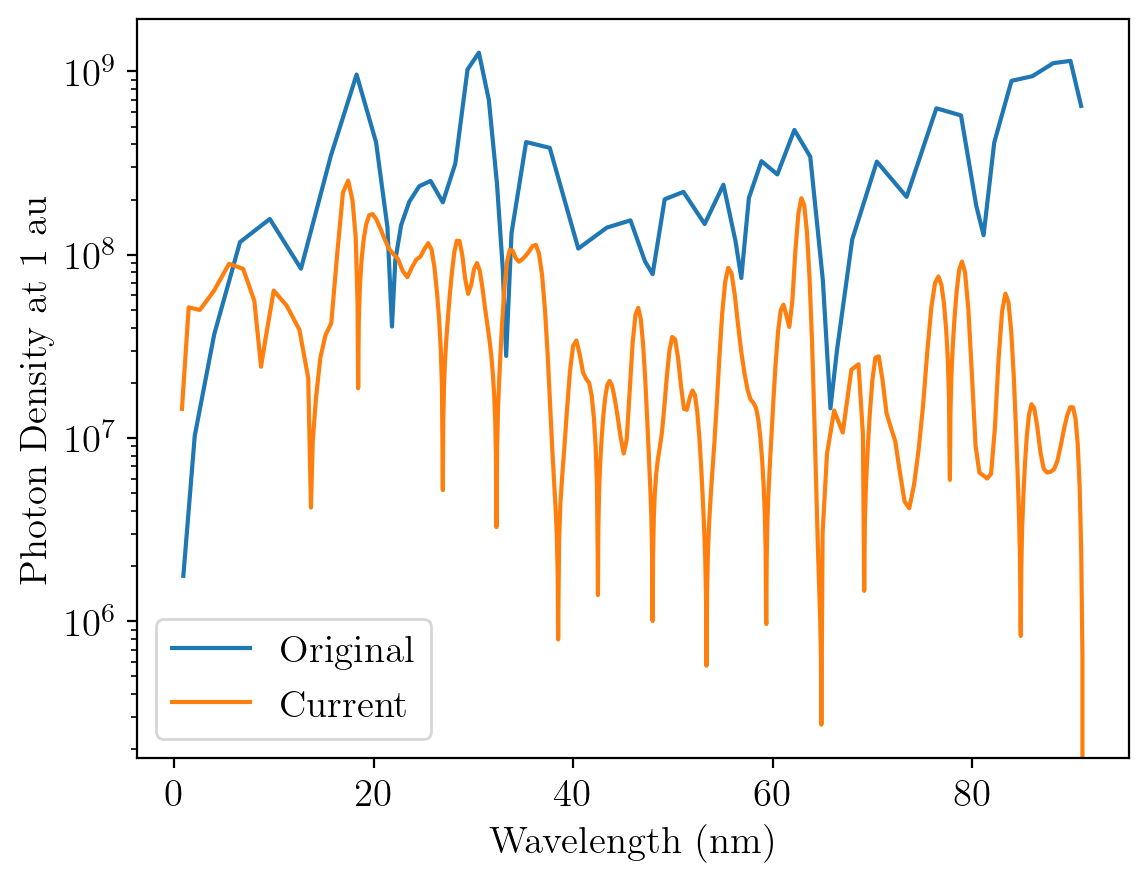

     Now ramping flux and spectral range.                                                                                                    

Goal: [ 0.61992127 91.16489319] nm                                                                                                    

Ramped spectrum wavelength range, now normalizing spectrum. 
Ramping Ftot from 1.096e+03 to 2.018e+03 ergs/s/cm2.                                                     
  Final:  Ftot:2.018338e+03, delta:0.05005                                                                      


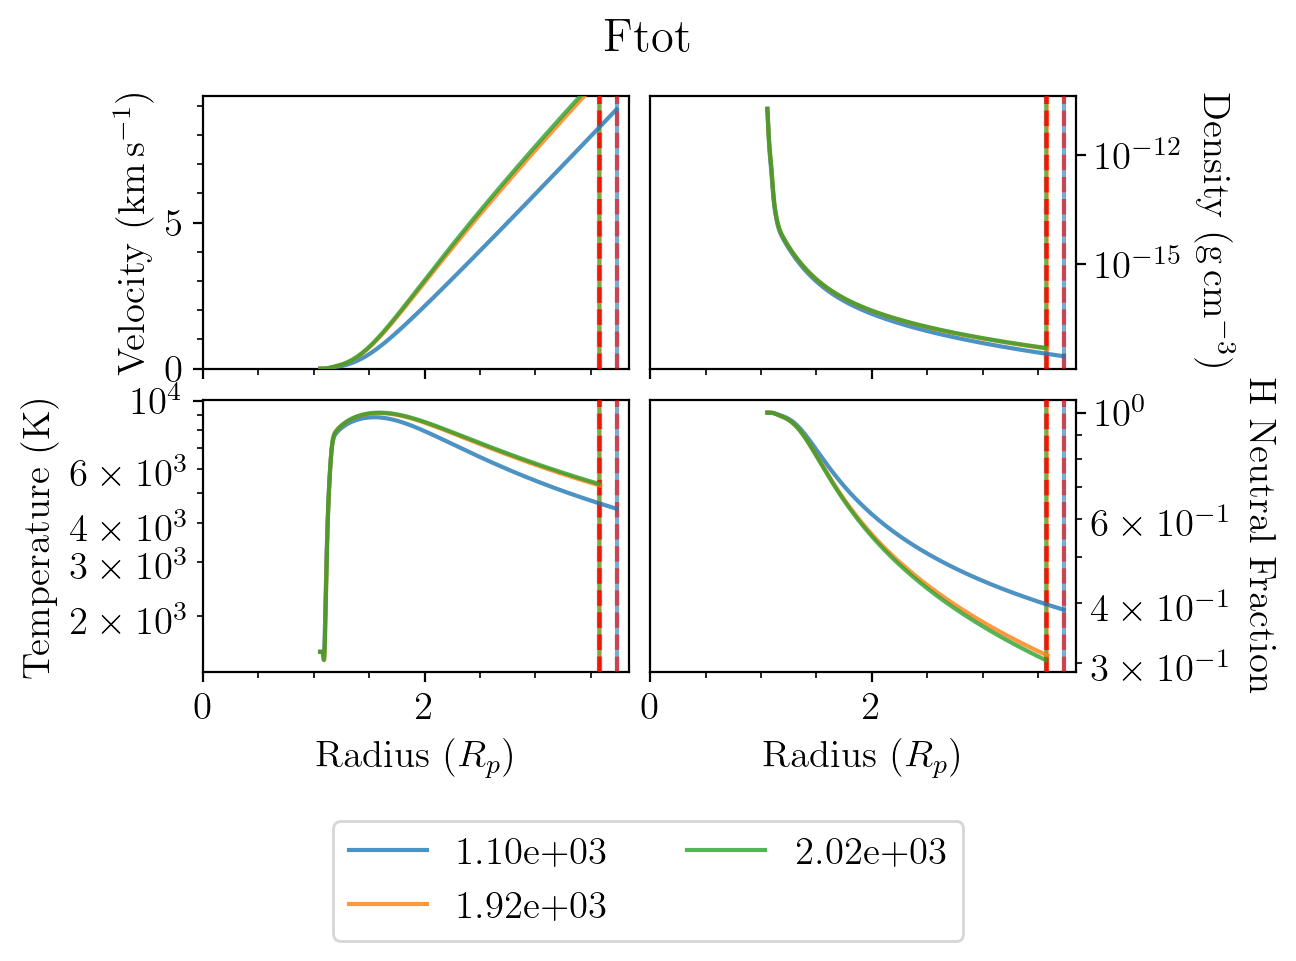

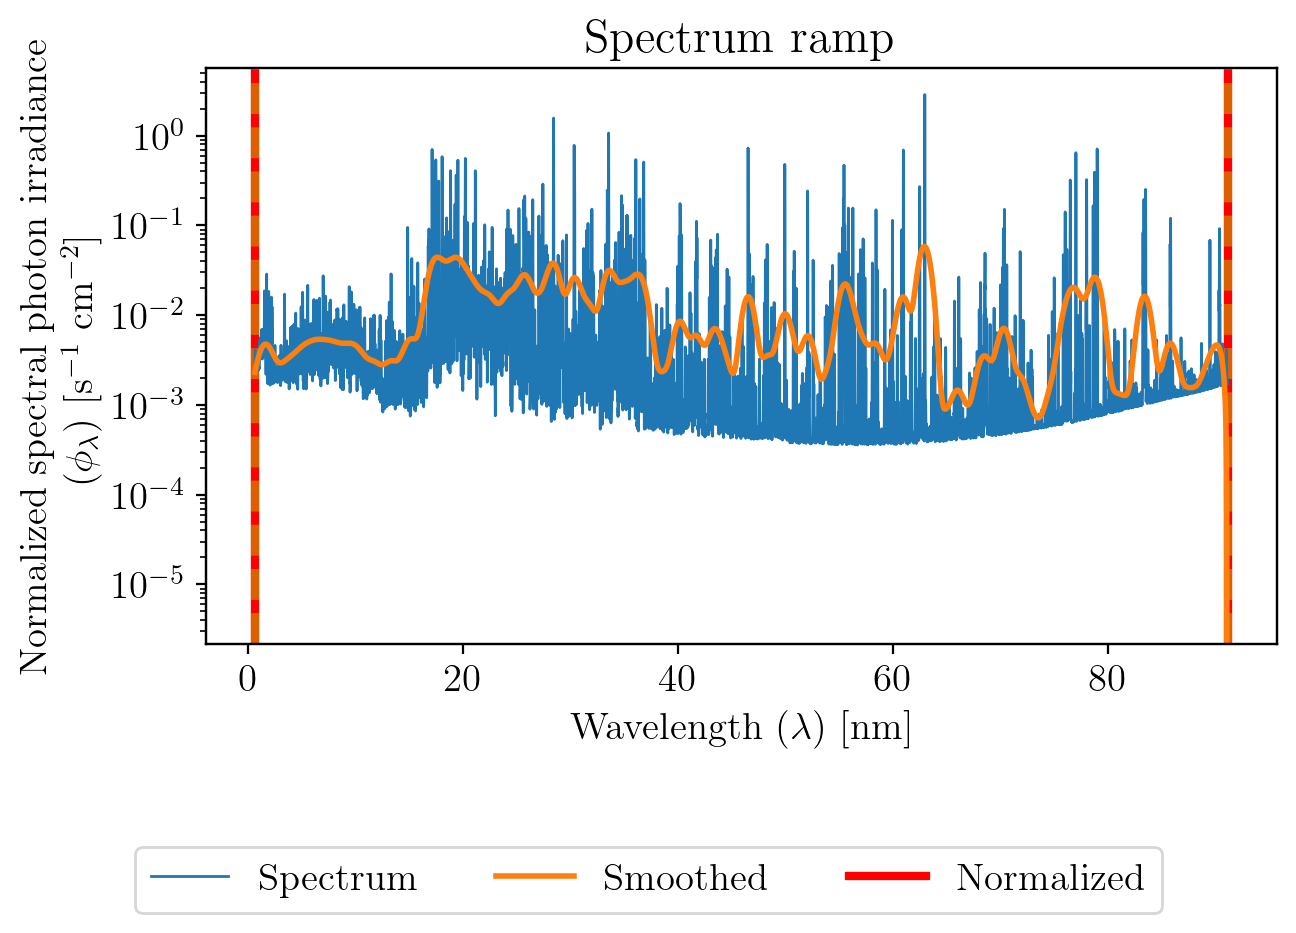

Success! Ramped to user-input stellar spectrum hd189733                                                                                                    



0

In [19]:
sim = wind_sim()
sim.load_planet('../saves/Tutorial_examples/example_13.6-2000eV_solar_H-He.csv',
               print_atmo=False)
sim.ramp_to_user_spectrum(spectrum_filename='hd189733',
                          species_list = ['HI','HeI'],
                          updated_F=2000,
                          goal_spec_range=[13.6,2000])

## 3. Metals - [Top](#top)
### Adding Metals <a id='metals'></a>
`Wind-AE`'s speed $\propto n_{species}$ so it is recommended to add metals last. If you are attempting to ramp far in parameter space, it may also be advisable to ramp with only H/He and add metals as a last step.

Future versions will include the ability to include multiple ionization states of the same element, but for now, select one ionization state per species.

This computation takes, on average, 5 minutes to add C I, N I, O I, Ne I, Mg II, Ca I.

If the ramper is having trouble ramping in metals, try raising the total column density (`sim.inputs.write_bcs(*sim.windsoln.bcs_tuple[0:5],sim.windsoln.Ncol_sp*5,sim.windsoln.bcs_tuple[-1])`+`sim.run_wind()`) or raising the stellar flux (`sim.ramp_var('Ftot',goal_F,converge=False)`).

In [20]:
sim = wind_sim()
sim.load_planet('../saves/Tutorial_examples/example_13.6-2000eV_solar_H-He.csv')

#printing the MASS fractions for Z x solar metallicity. 
sim.calc_metallicity(['HI','HeI','CI','NI','OI','NeI','MgII','CaI','SiII'],Z=1)

Atmosphere Composition
  Species:   HI,        HeI
  Mass frac: 8.00e-01, 2.00e-01



array([7.86635033e-01, 2.00365850e-01, 2.29916103e-03, 7.91792761e-04,
       6.70455672e-03, 1.75087019e-03, 6.49125426e-04, 6.36856785e-05,
       7.39925756e-04])

In [21]:
%%time
#default, Z=1, but can ramp
#in with higher Z or using custom MASS fractions
sim.add_metals(['CI','OI'],Z=1)

Metals added to guess, now ramping mass fractions.                                                                                        
Successfully ramped mass fracs. Integrating out & converging Ncol_sp...                                                                                                    

  ..Rmax 9.2070e+00, r_Cori 6.1380e+00                                                                                            
Successfully converged Rmax to 6.168703. It is recommended to run converge_Ncol_sp(integrate_out=True) as Ncol will have updated.                                                                                                    

CPU times: user 45.1 s, sys: 1.07 s, total: 46.2 s
Wall time: 1min 6s


0

In [22]:
sim.save_planet('../saves/Tutorial_examples/example_13.6-2000eV_solar_H-He-C-O.csv',
                polish=True, #can skip to save time
                overwrite=True)

Polishing up boundary conditions...
  ...Attempting Final Ncol Convergence.                                                                                           
Successfully converged Rmax to 6.168703 (Ncol also converged).                                                                                                    

   ...Trying: 1.153e-04, 1.297e-05. Current 7.020e-05, 2.510e-05. Goal 1.153e-04, 1.297e-05.                                      
  All boundary conditions succesfully polished to self-consistency.                                                                                                    

Saving ../saves/Tutorial_examples/example_13.6-2000eV_solar_H-He-C-O.csv


*****254.32Mearth_16.81Rearth_1095F_scaled-solar Mdot = 1.89e+10 g/s ******


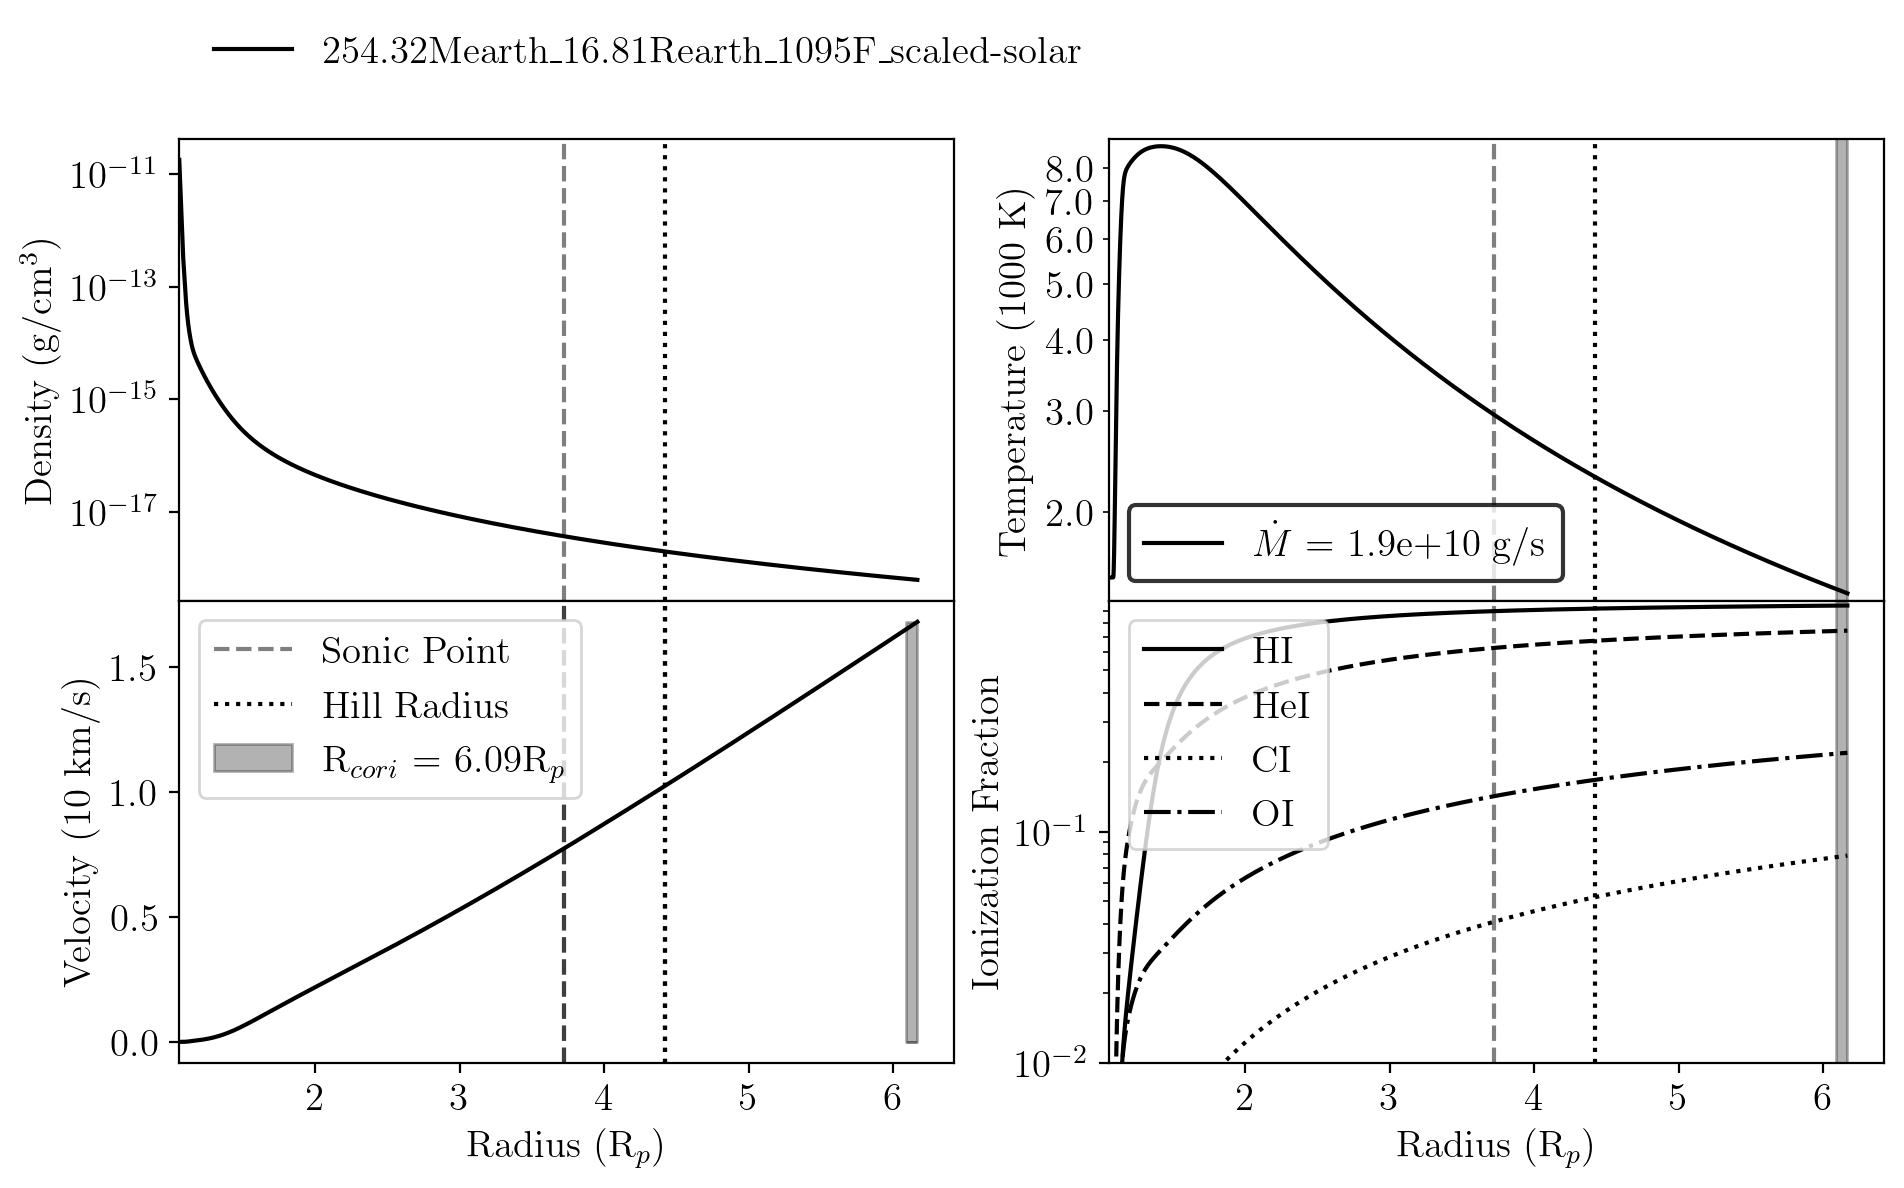

In [23]:
quick_plot(sim.windsoln)
plt.show()

### Ramping Metallicity <a id='metallicity'></a>
Can ramp in units of Z$_{solar}$ or to a custom mass fraction array.

In [24]:
sim = wind_sim()
sim.load_planet('../saves/Tutorial_examples/example_13.6-2000eV_solar_H-He-C-O.csv')

Atmosphere Composition
  Species:   HI,        HeI,        CI,        OI
  Mass frac: 7.90e-01, 2.01e-01, 2.31e-03, 6.73e-03



In [25]:
sim.ramp_metallicity(Z=10)

Starting metallicity: 1 xSolar
  Attempting to ramp Z from 1.0 to 10.0                                                                                           Success! Ramped to goal metallicity, Z = 10 x Solar
  Integrating out and attempting to converge Ncol_sp...
  ...Attempting Final Ncol Convergence.                                                                                           
Successfully converged Rmax to 6.067898 (Ncol also converged).                                                                                                    



0

In [26]:
sim.save_planet('../saves/Tutorial_examples/example_13.6-2000eV_solar_H-He-C-O_10Z.csv',
               polish=False,
               overwrite=True)

Saving ../saves/Tutorial_examples/example_13.6-2000eV_solar_H-He-C-O_10Z.csv


## 4. Saving in an easy output format <a id='output'></a> - [Top](#top)
Be nice to your collaborators and don't send them the complicated `Wind-AE` solution files. Instead, send a csv with just the columns you care about.

In [27]:
sim.easy_output_file(outputs=['v','T','rho','heat_ion'],
                     output_file='../saves/simplified_outputs/example.dat',
                     comments='Tutorial example planet w/ 10xZ_solar H,He,C,O. Scaled solar spectrum.',
                     overwrite=True)